# 0. Import Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score, 
                             balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score)

# 1. Data Loading and Overview

This dataset is a subset of the one provided by Vesta Corporation for the IEEE-CIS Fraud Detection Competition on the Kaggle platform. More information:
https://www.kaggle.com/competitions/ieee-fraud-detection/overview

In [2]:
transaction = pd.read_csv('train_transaction.csv')
identity = pd.read_csv('train_identity.csv')
data = transaction.merge(identity, how='left', on='TransactionID')
del transaction, identity

In [3]:
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [5]:
print(f'This dataset has {data.shape[1]} columns and {data.shape[0]} rows.\n')
print(f'{data.isnull().any().sum()} columns have missing values.\n')
one_value = [col for col in data.columns if data[col].nunique() <= 1]
print(f'There are {len(one_value)} columns in this dataset with one unique value.')

This dataset has 434 columns and 590540 rows.

414 columns have missing values.

There are 0 columns in this dataset with one unique value.


In [6]:
print('------------- Summary statistics for numerical features -------------')
print(data.describe())
print('\n------------- Summary statistics for categorical features -------------')
print(data.describe(include=['O']))

------------- Summary statistics for numerical features -------------
       TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000   

# 2. Initial Preprocessing 

## 2.0 Functions

In [7]:
def matchPatterns(df, patterns, col):
    """
    process a dataframe by matching and replacing string patterns in a 
    specified column with predefined names. Any category with a count 
    less than 20 is labeled as 'other'.
    
    Parameters:
    -df (pd.DataFrame): the dataframe
    -patterns (dict): the pattern dictionary
    -col (str): a column of the dataframe
    
    Returns:
    -df (pd.DataFrame): the dataframe after the changes
    """
    for pattern, name in patterns.items():
        df.loc[df[col].str.contains(pattern, na=False), col] = name

    counts = df[col].value_counts()
    df[col] = df[col].apply(lambda x: 'other' if pd.notna(x) and counts[x] < 20 else x)
    
    return df

## 2.1 Removing Outliers

In [8]:
z_scores = stats.zscore(data['TransactionAmt'])
non_outliers = np.abs(z_scores) <= 3

num_rows_before = len(data) # before removing outliers
data = data[non_outliers]
num_rows_after = len(data) # after removing outliers

print(f"{num_rows_before-num_rows_after} rows were removed, because they contained outliers.")

10093 rows were removed, because they contained outliers.


## 2.2 Dropping Columns with Missing Values > 90%

In [9]:
threshold = 0.90
data.dropna(thresh=int((1 - threshold) * len(data)), axis=1, inplace=True)

## 2.3 Feature Engineering

* Creating 4 different variables, based on the purchaser's and recipient's email server and the suffix.
* id_30 contains information about operating systems. OS versions are considered unnecessary, so we only kept the os. 
* id_33 contains information about the size of the screen used. We created two separate numerical variables, one for width and one for height.

In [10]:
data[['P_emailserver', 'P_suffix']] = data['P_emaildomain'].str.split('.', n=1, expand=True)
data[['R_emailserver', 'R_suffix']] = data['R_emaildomain'].str.split('.', n=1, expand=True)
data['os'] = data['id_30'].str.split(' ', expand=True)[0]
data['screen_width'] = data['id_33'].str.split('x', expand=True)[0]
data['screen_height'] = data['id_33'].str.split('x', expand=True)[1]
data['screen_width'] = pd.to_numeric(data['screen_width'])
data['screen_height'] = pd.to_numeric(data['screen_height'])

* id_31 contains information about browsers. 
* DeviceInfo contains information about the type of device. 

We kept only basic information, through splitting and mapping. Also renamed as 'other' all the values that were found less than 20 times.

In [11]:
data['browser'] = data['id_31'].str.split(' ', expand=True)[0].str.lower()
data['device_name'] = data['DeviceInfo'].str.split(' ', expand=True)[0].str.lower()

browser_patterns = {
    r'samsung/sm-g532m|samsung/sch|samsung/sm-g531h': 'samsung',
    r'generic/android': 'android',
    r'mozilla/firefox': 'firefox',
    r'nokia/lumia': 'nokia',
    r'zte/blade': 'zte',
    r'lg/k-200': 'lg',
    r'lanix/ilium': 'lanix',
    r'blu/dash': 'blu',
    r'm4tel/m4': 'm4'
}

device_patterns = {
    r'samsung|sgh|sm|gt-': 'samsung',
    r'mot': 'motorola',
    r'ale-|.*-l|hi': 'huawei',
    r'lg': 'lg',
    r'rv:': 'rv',
    r'blade': 'zte',
    r'xt': 'sony',
    r'iphone': 'ios',
    r'lenovo': 'lenovo',
    r'mi|redmi': 'xiaomi',
    r'ilium': 'ilium',
    r'alcatel': 'alcatel',
    r'asus': 'asus'
}

data = matchPatterns(data, browser_patterns, 'browser')
data = matchPatterns(data, device_patterns, 'device_name')

* TransactionDT values are from 86.400 to 15.811.131. It was found that the unit is seconds, starting from day one (60 * 60 * 24 = 86.400) and ending in day 183 (15.811.131 / 86.400 = 182,999). So the dataset spans 6 months, from 01/12/2017 to 31/05/2018.

(Further information can be found on the discussion section of the competition)

In [12]:
start_date = datetime(2017, 11, 30)
data['TransactionFullDate'] = data['TransactionDT'].apply(lambda x: start_date + timedelta(seconds=x))
data['TransactionDate'] = data['TransactionFullDate'].dt.date
data['DayOfWeek'] = data['TransactionFullDate'].dt.dayofweek.apply(lambda x: (x + 1) % 7)    # Sunday=0, Monday=1, Tuesday=2, etc
data['HourOfDay'] = data['TransactionFullDate'].dt.hour   # from 0 to 23
data['Month'] = data['TransactionFullDate'].dt.month

In this part we create aggregated variables using groupby:
* Transaction count per hour of the day, per day of the week, per month
* Transaction mean amount per hour of the day, per day of the week, per month
* Transaction fraud rate per hour of the day, per day of the week, per month
* Transaction fraud rate per product code (ProductCD), per credit card company (card4), per type of credit card (card6), per device type

In [13]:
data['Count_DayOfWeek'] = data.groupby('DayOfWeek')['TransactionID'].transform('count')
data['Count_HourOfDay'] = data.groupby('HourOfDay')['TransactionID'].transform('count')
data['Count_Month'] = data.groupby('Month')['TransactionID'].transform('count')

data['MeanAmt_DayOfWeek'] = data.groupby('DayOfWeek')['TransactionAmt'].transform('mean')
data['MeanAmt_HourOfDay'] = data.groupby('HourOfDay')['TransactionAmt'].transform('mean')
data['MeanAmt_Month'] = data.groupby('Month')['TransactionAmt'].transform('mean')

data['FraudRate_DayOfWeek'] = data.groupby('DayOfWeek')['isFraud'].transform('mean')
data['FraudRate_HourOfDay'] = data.groupby('HourOfDay')['isFraud'].transform('mean')
data['FraudRate_Month'] = data.groupby('Month')['isFraud'].transform('mean')

data['FraudRate_ProductCD'] = data.groupby('ProductCD')['isFraud'].transform('mean')
data['FraudRate_card4'] = data.groupby('card4')['isFraud'].transform('mean')
data['FraudRate_card6'] = data.groupby('card6')['isFraud'].transform('mean')
data['FraudRate_DeviceType'] = data.groupby('DeviceType')['isFraud'].transform('mean')

## 2.4 Data Scaling

In [14]:
d_columns = [col for col in data.columns if re.match(r'^D\d+$', col)]
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(data[d_columns])
data[d_columns] = scaled_values

# 3. Exploratory Data Analysis

## 3.0 Functions

In [15]:
def descriptiveStats(df, column):
    """
    calculate and return descriptive statistics for a column in a dataframe, 
    such as count, mean, standard deviation, min, max, quartiles, additionally 
    skewness and kurtosis.

    Parameters:
    df (pd.DataFrame): the dataframe containing the column.
    column (str): the column for which descriptive statistics are to be calculated.

    Returns:
    desc_stats (pd.Series): the descriptive statistics for the column.
    """
    desc_stats = df[column].describe()
    desc_stats['skewness'] = stats.skew(df[column].dropna())
    desc_stats['kurtosis'] = stats.kurtosis(df[column].dropna())
    
    return desc_stats

def plotTransactionAmt(column, color, title):
    """
    plots a histogram for daily transaction amounts.

    Parameters:
    column (pd.Series): a dataframe column containing the amount of each transaction.
    color (str): the color to use for the histogram
    title (str): the title of the plot
    """
    sns.histplot(column, bins=50, kde=True, color=color)
    plt.title(title)
    plt.xlabel('TransactionAmt')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


def plotPercentages(column, labels, df, figsize=(10, 6)):
    """
    plot the percentage of fraud and not fraud transactions for the categories of the input column.

    Parameters:
    -column (str): the column, the categories of which are to be plotted
    -labels (list): the labels of the categories
    -df (pd.DataFrame): the dataframe, containing the column and 'isFraud'
    -figsize (tuple): the size of the figure, with default value (10, 6)
    """
    if column == 'Month':
        counts = pd.DataFrame({
            0: df[df['isFraud'] == 0].groupby('Month').size().reindex([12, 1, 2, 3, 4, 5], fill_value=0),
            1: df[df['isFraud'] == 1].groupby('Month').size().reindex([12, 1, 2, 3, 4, 5], fill_value=0)
        })
        
    else:
        counts = df.groupby([column, 'isFraud']).size().unstack(fill_value=0)

    total_count = counts.sum(axis=1).sum()

    fraud_percentages = counts[1] / total_count * 100
    not_fraud_percentages = counts[0] / total_count * 100

    # Plotting
    ind = range(len(labels))  # the x locations for the groups

    plt.figure(figsize=figsize)
    bars1 = plt.bar(ind, not_fraud_percentages, label='isFraud=0 | Not Fraud', color='#9cdba8')
    bars2 = plt.bar(ind, fraud_percentages, bottom=not_fraud_percentages, label='isFraud=1 | Fraud', color='#ff785c')

    # Adding percentage values on the bars
    for i, (not_fraud_pct, fraud_pct) in enumerate(zip(not_fraud_percentages, fraud_percentages)):
        plt.text(ind[i], not_fraud_pct / 2, f'{not_fraud_pct:.2f}%', ha='center', va='center', color='black')
        plt.text(ind[i], not_fraud_pct + fraud_pct / 2, f'{fraud_pct:.2f}%', ha='center', va='center', color='black')

    plt.title(f'(Not) Fraud Percentage per {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Percentage of Transactions')
    plt.xticks(ticks=ind, labels=labels)
    plt.legend()
    plt.show()
    
def countPercentageTable(df, column):
    """
    create a table with the counts and percentages of transactions per category of the column,
    as well as the counts and percentages of fraudulent and not fraudulent transactions.

    Parameters:
    - column (str): the column, the categories of which are to be plotted
    - df (pd.DataFrame): the dataframe, containing the column and 'isFraud'
    """
    total_transactions = df.shape[0]
    missing_values_count = df[column].isna().sum()
    filtered_df = df[df[column].notna()]
    
    # each category
    category_counts = filtered_df[column].value_counts().reset_index()
    category_counts.columns = [column, 'Total Count']
    category_counts['Total Percentage'] = (category_counts['Total Count'] / total_transactions * 100).round(2)
    
    # non-fraudulent transactions
    non_fraud_df = filtered_df[filtered_df['isFraud'] == 0]
    non_fraud_counts = non_fraud_df[column].value_counts().reset_index()
    non_fraud_counts.columns = [column, 'Not-Fraud Count']
    non_fraud_counts['Not-Fraud Percentage'] = (non_fraud_counts['Not-Fraud Count'] / total_transactions * 100).round(2)

    # fraudulent transactions
    fraud_df = filtered_df[filtered_df['isFraud'] == 1]
    fraud_counts = fraud_df[column].value_counts().reset_index()
    fraud_counts.columns = [column, 'Fraud Count']
    fraud_counts['Fraud Percentage'] = (fraud_counts['Fraud Count'] / total_transactions * 100).round(2)

    result = pd.merge(category_counts, non_fraud_counts, on=column, how='left')
    result = pd.merge(result, fraud_counts, on=column, how='left')
    result.fillna(0, inplace=True)
    result = result[[column, 'Total Count', 'Not-Fraud Count', 'Fraud Count', 'Total Percentage', 'Not-Fraud Percentage', 'Fraud Percentage']]
    
    missing_values_percentage = round(missing_values_count / total_transactions * 100, 2)
    missing_values_df = pd.DataFrame({
        column: ['Missing Values'],
        'Total Count': [missing_values_count],
        'Not-Fraud Count': ['-'],
        'Fraud Count': ['-'],
        'Total Percentage': [missing_values_percentage],
        'Not-Fraud Percentage': ['-'],
        'Fraud Percentage': ['-']
    })
    result = pd.concat([result, missing_values_df], ignore_index=True)
    
    print(result)

In [16]:
def plotProductCD(df):
    """
    Plot the percentage of fraud and not fraud transactions for each product code.

    Parameters:
    - df (pd.DataFrame): the dataframe, containing the columns 'ProductCD' and 'isFraud'
    """
    counts = df.groupby(['ProductCD', 'isFraud']).size().unstack(fill_value=0)
    total_count = counts.sum().sum()
    fraud_percentages = counts[1] / total_count * 100
    not_fraud_percentages = counts[0] / total_count * 100

    labels = counts.index.tolist()
    ind = range(len(labels))

    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(ind, not_fraud_percentages, label='isFraud=0 | Not Fraud', color='#9cdba8')
    bars2 = plt.bar(ind, fraud_percentages, bottom=not_fraud_percentages, label='isFraud=1 | Fraud', color='#ff785c')

    for i, (not_fraud_pct, fraud_pct) in enumerate(zip(not_fraud_percentages, fraud_percentages)):
        plt.text(ind[i], not_fraud_pct / 2, f'{not_fraud_pct:.2f}%', ha='center', va='center', color='black')
        if fraud_pct < 1:
            plt.annotate(f'{fraud_pct:.2f}%',
                         xy=(ind[i], not_fraud_pct + fraud_pct),
                         xytext=(ind[i], not_fraud_pct + fraud_pct + 15),
                         textcoords='offset points',
                         ha='center', va='bottom', fontsize=10, color='black',
                         arrowprops=dict(facecolor='black', arrowstyle='->'))
        else:
            plt.text(ind[i], not_fraud_pct + fraud_pct / 2, f'{fraud_pct:.2f}%', ha='center', va='center', color='black')

    plt.title('(Not) Fraud Percentage per ProductCD')
    plt.xlabel('ProductCD')
    plt.ylabel('Percentage of Transactions')
    plt.xticks(ticks=ind, labels=labels)
    plt.legend()
    plt.show()

def plotDeviceType(df):
    """
    Plot the percentage of fraud and not fraud transactions for each device type.

    Parameters:
    - df (pd.DataFrame): The dataframe, containing the columns 'DeviceType' and 'isFraud'.
    """
    # a copy of the DataFrame to avoid modifying the original dataset
    df_copy = df.copy()
    df_copy['DeviceType'].fillna('Missing values', inplace=True)
    
    counts = df_copy.groupby(['DeviceType', 'isFraud']).size().unstack(fill_value=0)
    total_count = counts.sum().sum()
    fraud_percentages = counts[1] / total_count * 100
    not_fraud_percentages = counts[0] / total_count * 100

    labels = counts.index.tolist()
    
    # Handle missing values
    missing_index = None
    if 'Missing values' in labels:
        missing_index = labels.index('Missing values')
        combined_percentage = fraud_percentages.iloc[missing_index] + not_fraud_percentages.iloc[missing_index]
        fraud_percentages.iloc[missing_index] = combined_percentage
        not_fraud_percentages.iloc[missing_index] = 0
        colors_not_fraud = ['#9cdba8' if i != missing_index else '#949997' for i in range(len(labels))]
        colors_fraud = ['#ff785c' if i != missing_index else '#949997' for i in range(len(labels))]
    else:
        colors_not_fraud = ['#9cdba8'] * len(labels)
        colors_fraud = ['#ff785c'] * len(labels)

    ind = range(len(labels))
    figsize = (10, 6)

    plt.figure(figsize=figsize)

    # Plot the bars
    bars1 = plt.bar(ind, not_fraud_percentages, label='isFraud=0 | Not Fraud', color=colors_not_fraud)
    bars2 = plt.bar(ind, fraud_percentages, bottom=not_fraud_percentages, color=colors_fraud)

    for i, (not_fraud_pct, fraud_pct) in enumerate(zip(not_fraud_percentages, fraud_percentages)):
        if missing_index is not None and i == missing_index:
            plt.text(ind[i], fraud_pct / 2, f'{fraud_pct:.2f}%', ha='center', va='center', color='black')
        else:
            plt.text(ind[i], not_fraud_pct / 2, f'{not_fraud_pct:.2f}%', ha='center', va='center', color='black')
            if fraud_pct < 1:
                plt.annotate(f'{fraud_pct:.2f}%',
                             xy=(ind[i], not_fraud_pct + fraud_pct),
                             xytext=(ind[i], not_fraud_pct + fraud_pct + 15),
                             textcoords='offset points',
                             ha='center', va='bottom', fontsize=10, color='black',
                             arrowprops=dict(facecolor='black', arrowstyle='->'))
            else:
                plt.text(ind[i], not_fraud_pct + fraud_pct / 2, f'{fraud_pct:.2f}%', ha='center', va='center', color='black')

    plt.title('(Not) Fraud Percentage per DeviceType')
    plt.xlabel('DeviceType')
    plt.ylabel('Percentage of Transactions')
    plt.xticks(ticks=ind, labels=labels)

    legend_patches = [Patch(color='#9cdba8', label='isFraud=0 | Not Fraud'),
                      Patch(color='#ff785c', label='isFraud=1 | Fraud')]
    if missing_index is not None:
        legend_patches.append(Patch(color='#949997', label='Missing values'))
        
    plt.legend(handles=legend_patches)
    plt.show()

## 3.1 Target Distribution

In [17]:
print('The percentage of fraudulent transactions in this dataset is {:.1f}%'.format(100*data['isFraud'].mean()))

The percentage of fraudulent transactions in this dataset is 3.5%


## 3.2 Exploration of TransactionAmt

In [18]:
overall_stats = descriptiveStats(data, 'TransactionAmt')
non_fraud_stats = descriptiveStats(data[data['isFraud'] == 0], 'TransactionAmt')
fraud_stats = descriptiveStats(data[data['isFraud'] == 1], 'TransactionAmt')

stats_df = pd.DataFrame({
    'Overall': overall_stats,
    'Non-Fraud': non_fraud_stats,
    'Fraud': fraud_stats
})  

print(stats_df)

                Overall      Non-Fraud         Fraud
count     580447.000000  560322.000000  20125.000000
mean         111.261519     110.902453    121.258686
std          118.139961     117.542520    133.321908
min            0.251000       0.251000      0.292000
25%           42.536000      42.950000     34.000000
50%           67.950000      67.950000     70.384000
75%          117.000000     117.000000    150.000000
max          852.470000     852.470000    851.000000
skewness       2.676976       2.701961      2.118375
kurtosis       8.718803       8.908363      4.961371


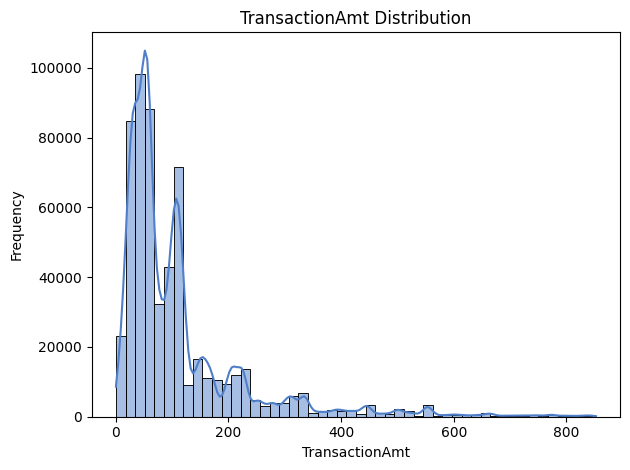

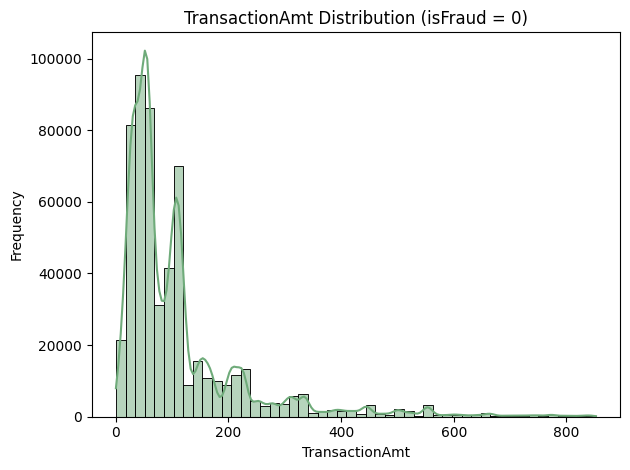

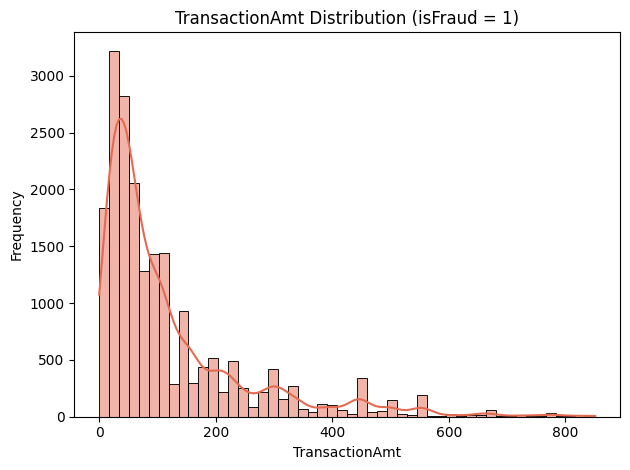

In [19]:
plotTransactionAmt(data['TransactionAmt'], '#4f7fc9', 'TransactionAmt Distribution')
plotTransactionAmt(data[data['isFraud'] == 0]['TransactionAmt'], '#6fab7a', 'TransactionAmt Distribution (isFraud = 0)')
plotTransactionAmt(data[data['isFraud'] == 1]['TransactionAmt'], '#e36b52', 'TransactionAmt Distribution (isFraud = 1)')

## 3.3 Transaction Count per Day

In [20]:
data.groupby('TransactionDate').size().reset_index(name='Transaction Count').describe()

,Transaction Count
count,182.000000
mean,3189.269231
std,816.767526
min,2020.000000
25%,2742.750000
50%,2989.000000
75%,3341.000000
max,6752.000000


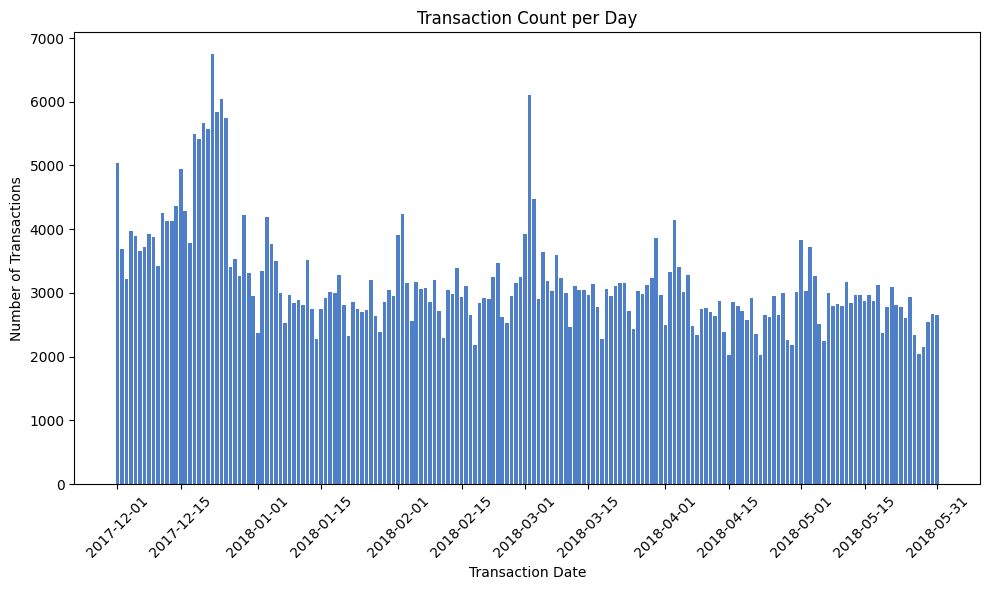

In [21]:
daily_counts = data.groupby('TransactionDate').size().reset_index(name='Count')
plt.figure(figsize=(10, 6))
plt.bar(daily_counts['TransactionDate'], daily_counts['Count'], width=0.8, color='#4f7fc9')
plt.xlabel('Transaction Date')
plt.ylabel('Number of Transactions')
plt.title('Transaction Count per Day')

ticks = pd.to_datetime(['2017-12-01', '2017-12-15', '2018-01-01', '2018-01-15', '2018-02-01', '2018-02-15', 
        '2018-03-01', '2018-03-15', '2018-04-01', '2018-04-15', '2018-05-01', '2018-05-15', '2018-05-31'])
plt.xticks(ticks, rotation=45)


plt.tight_layout()
plt.show()

## 3.4 (Not) Fraud Percentage per hour of the day, day of the week, month

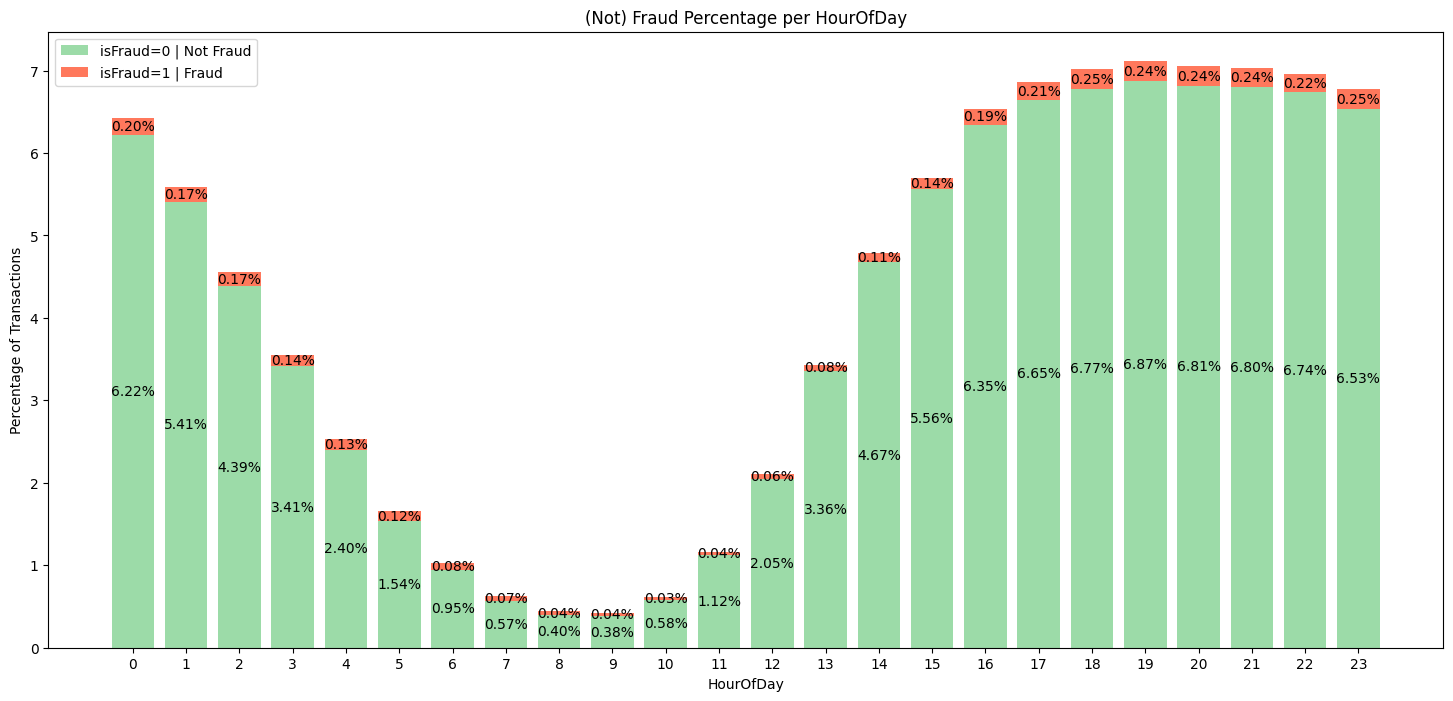

In [22]:
hours = list(range(24))
plotPercentages('HourOfDay', hours, data, (18,8))

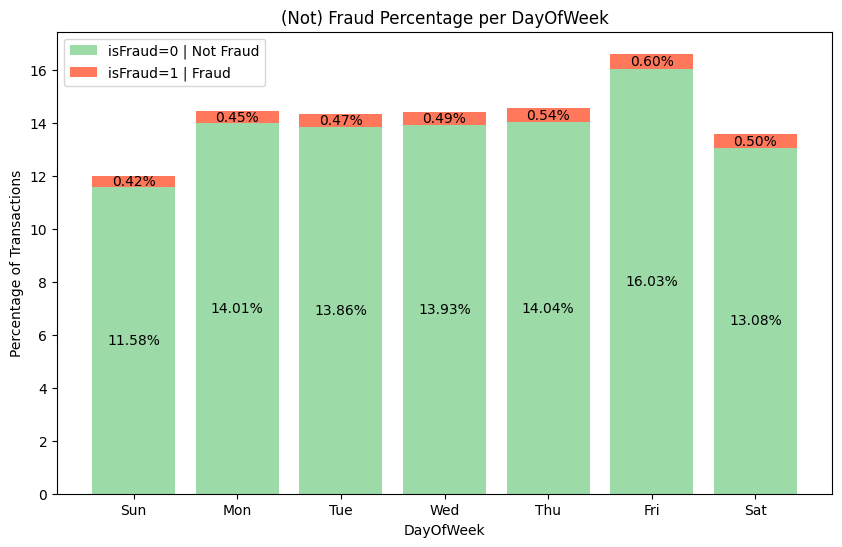

In [23]:
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
plotPercentages('DayOfWeek', days, data)

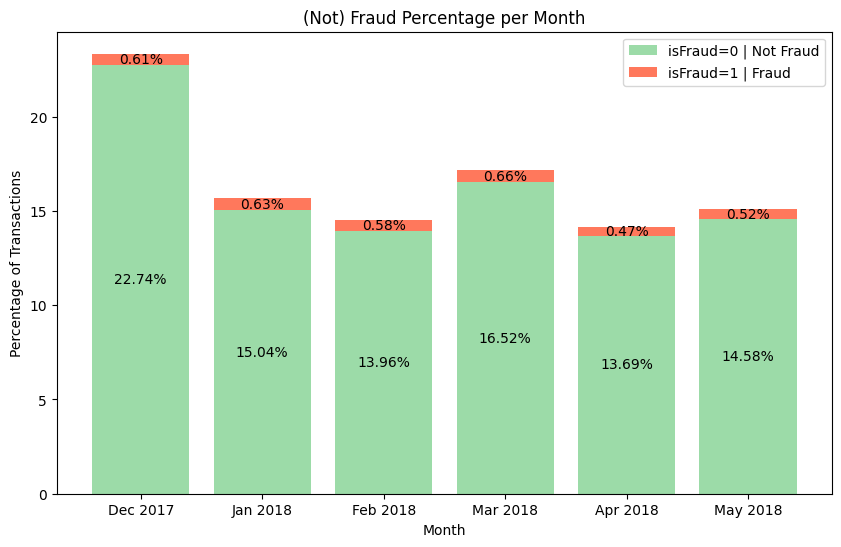

In [24]:
months = ['Dec 2017', 'Jan 2018', 'Feb 2018', 'Mar 2018', 'Apr 2018', 'May 2018']
plotPercentages('Month', months, data)

## 3.5 (Not) Fraud Percentage per other columns

In [25]:
countPercentageTable(data, 'ProductCD')

        ProductCD  Total Count Not-Fraud Count Fraud Count  Total Percentage  \
0               W       430019          421571        8448             74.08   
1               C        68519           60511        8008             11.80   
2               R        37276           35867        1409              6.42   
3               H        33024           31450        1574              5.69   
4               S        11609           10923         686              2.00   
5  Missing Values            0               -           -              0.00   

  Not-Fraud Percentage Fraud Percentage  
0                72.63             1.46  
1                10.42             1.38  
2                 6.18             0.24  
3                 5.42             0.27  
4                 1.88             0.12  
5                    -                -  


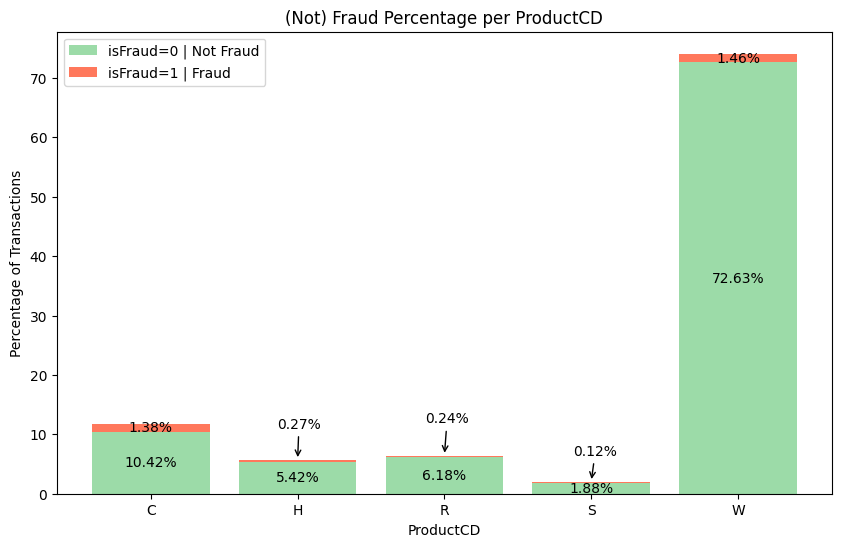

In [26]:
plotProductCD(data)

In [27]:
countPercentageTable(data, 'DeviceType')

       DeviceType  Total Count Not-Fraud Count Fraud Count  Total Percentage  \
0         desktop        84780           79228        5552             14.61   
1          mobile        55601           49959        5642              9.58   
2  Missing Values       440066               -           -             75.82   

  Not-Fraud Percentage Fraud Percentage  
0                13.65             0.96  
1                 8.61             0.97  
2                    -                -  


C:\Users\dhanu\AppData\Local\Temp\ipykernel_17828\1826235347.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['DeviceType'].fillna('Missing values', inplace=True)


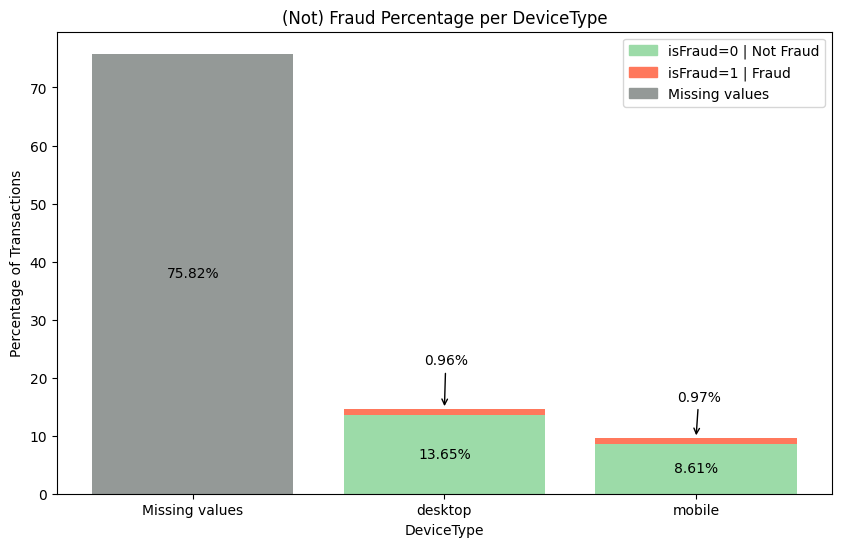

In [28]:
plotDeviceType(data)

In [29]:
countPercentageTable(data, 'card4')

              card4  Total Count Not-Fraud Count Fraud Count  \
0              visa       378463          365450       13013   
1        mastercard       186045          179649        6396   
2  american express         8225            7986         239   
3          discover         6171            5735         436   
4    Missing Values         1543               -           -   

   Total Percentage Not-Fraud Percentage Fraud Percentage  
0             65.20                62.96             2.24  
1             32.05                30.95              1.1  
2              1.42                 1.38             0.04  
3              1.06                 0.99             0.08  
4              0.27                    -                -  


In [30]:
countPercentageTable(data, 'card6')

             card6  Total Count Not-Fraud Count Fraud Count  Total Percentage  \
0            debit       435111          424618     10493.0             74.96   
1           credit       143754          134161      9593.0             24.77   
2  debit or credit           30              30         0.0              0.01   
3      charge card           15              15         0.0              0.00   
4   Missing Values         1537               -           -              0.26   

  Not-Fraud Percentage Fraud Percentage  
0                73.15             1.81  
1                23.11             1.65  
2                 0.01              0.0  
3                  0.0              0.0  
4                    -                -  


## 3.6 Correlation Analysis for Vs

In [31]:
v_columns = [col for col in data.columns if re.match(r'^V\d+$', col)]

correlation_matrix = data[v_columns].corr().abs()
np.fill_diagonal(correlation_matrix.values, np.nan)
high_corr_pairs = np.where(correlation_matrix > 0.8)
unique_vars = set(high_corr_pairs[0]).union(set(high_corr_pairs[1]))
num_unique_vars = len(unique_vars)

print(f"Number of V-variables that appear in at least one highly correlated pair (>80%): {num_unique_vars}")

Number of V-variables that appear in at least one highly correlated pair (>80%): 298


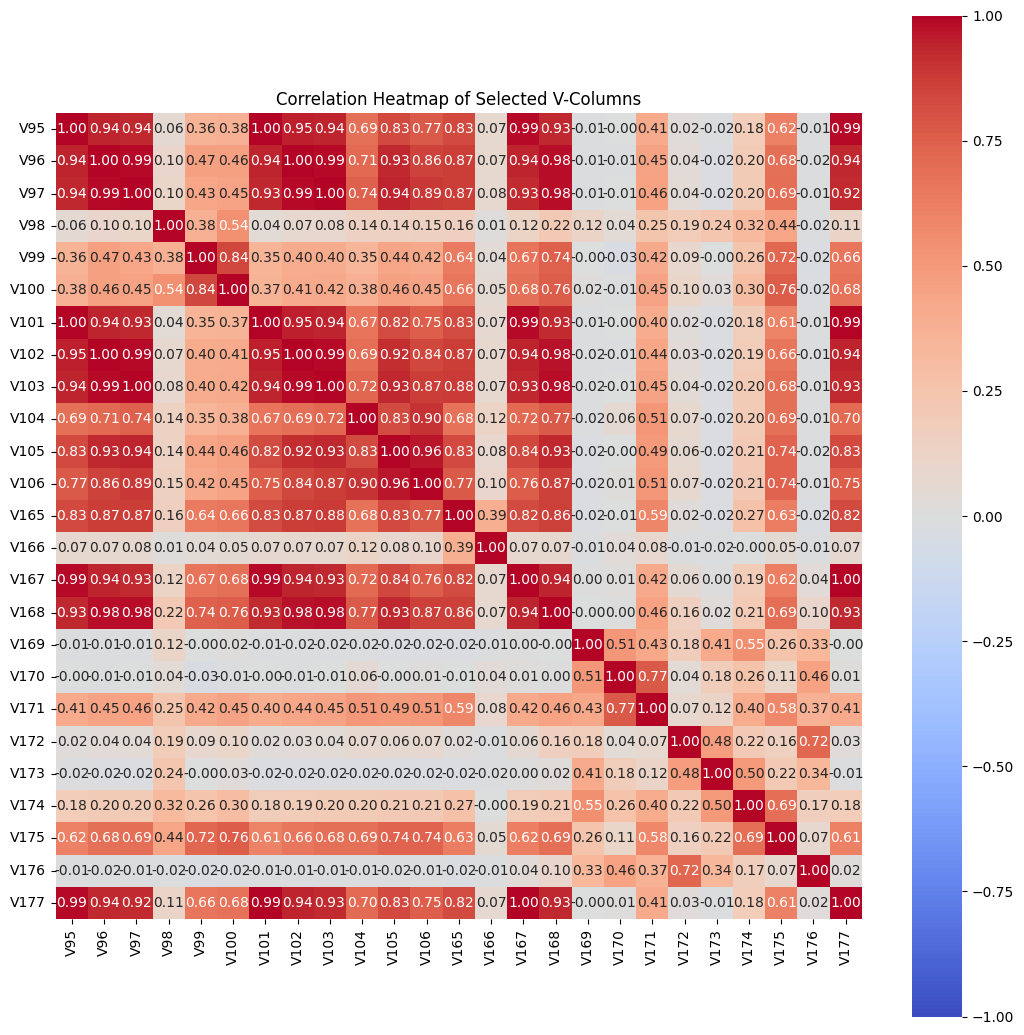

In [32]:
subset = data[['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 
               'V104', 'V105', 'V106', 'V165', 'V166', 'V167', 'V168', 'V169', 
               'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177']]

corr_matrix = subset.corr()
plt.figure(figsize=(13, 13))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, square=True)
plt.title('Correlation Heatmap of Selected V-Columns')
plt.show()

# 4. Final Preprocessing

## 4.0 Functions

In [33]:
def reduceMemoryUsage(df):
    """
    iterate through the columns of a dataframe and 
    change the data type in order to reduce memory usage.
    
    Parameters:
    -df (pd.DataFrame): the dataframe
    
    Returns:
    -df (pd.DataFrame): the dataframe after the changes
    """
    
    start = df.memory_usage().sum() / 1024**2
    print('Starting memory usage of the dataframe: {:.2f} MB'.format(start))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if str(col_type).startswith('float'):
            col_min = df[col].min()
            col_max = df[col].max()
            if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type).startswith('int'):
            col_min = df[col].min()
            col_max = df[col].max()
            if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
        else:
            df[col] = df[col].astype('category')

    end = df.memory_usage().sum() / 1024**2
    print('Memory usage after downsizing: {:.2f} MB'.format(end))
    print('Memory usage decreased by {:.1f}%'.format(100 * (start - end) / start))         
            
            
    return df

## 4.1 Deleting unnecessary columns 

In [34]:
data.drop(columns=['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo', 'TransactionDT', 'TransactionFullDate', 'TransactionDate', 'TransactionID'], inplace=True)

## 4.2 Missing Values Imputation

In [35]:
data.fillna(-999, inplace=True)

## 4.3 Categorical Data Encoding

In [36]:
numerical_columns = []
categorical_columns = []
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        numerical_columns.append(col)
    else:
        categorical_columns.append(col)

In [37]:
le = LabelEncoder()
for col in categorical_columns:
    data[col] = data[col].astype(str)
    data[col] = le.fit_transform(data[col])

## 4.4 Reduce Memory Usage

In [38]:
data = reduceMemoryUsage(data)

Starting memory usage of the dataframe: 1877.67 MB
Memory usage after downsizing: 524.77 MB
Memory usage decreased by 72.1%


# 5. Dimensionality Reduction

In [39]:
v_data_standardized = StandardScaler().fit_transform(data[v_columns])

pca = PCA().fit(v_data_standardized)
v_data_pca = pca.transform(v_data_standardized)
explained_variance = pca.explained_variance_ratio_.cumsum()

In [40]:
# Kaiser criterion (eigenvalues > 1)
num_components_kaiser = sum(eigenvalue > 1 for eigenvalue in pca.explained_variance_)
print(f"Number of components to retain (Kaiser criterion): {num_components_kaiser}")

Number of components to retain (Kaiser criterion): 19


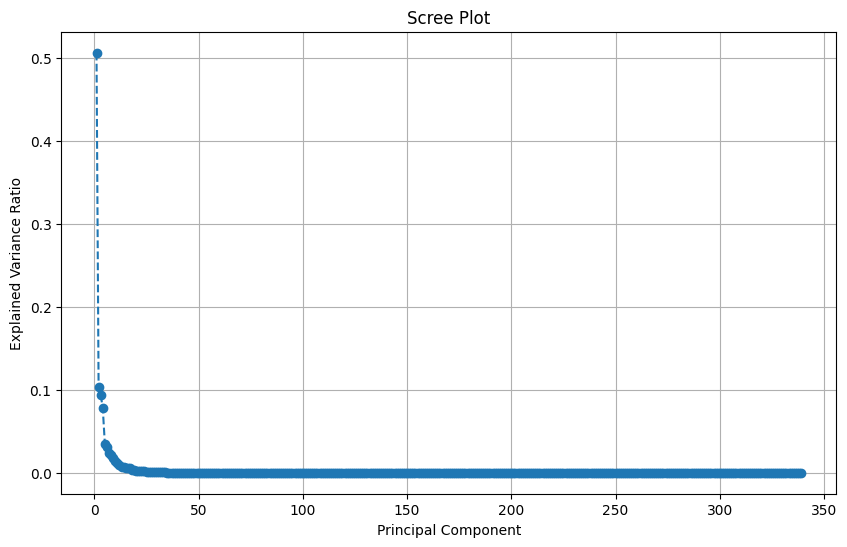

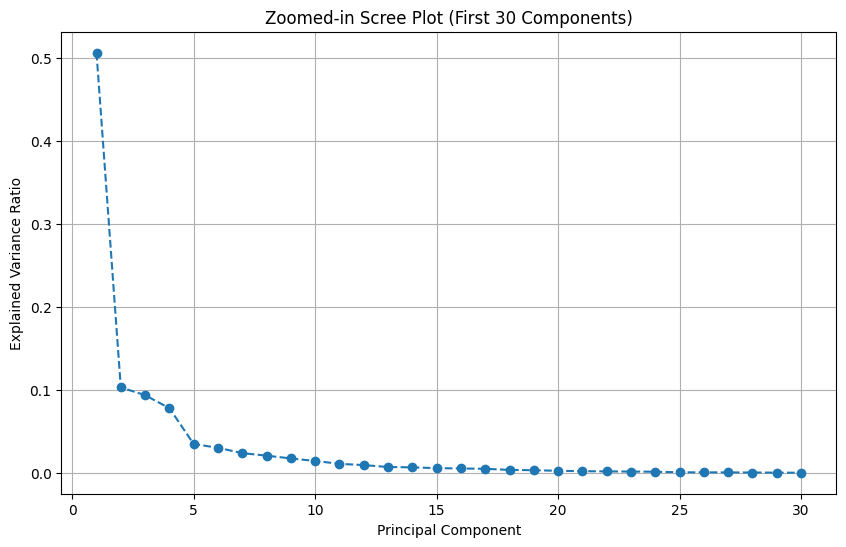

In [41]:
# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid()
plt.show()

# Zoomed-in scree plot (x-axis up to 30)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), pca.explained_variance_ratio_[:30], marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Zoomed-in Scree Plot (First 30 Components)')
plt.grid()
plt.show()

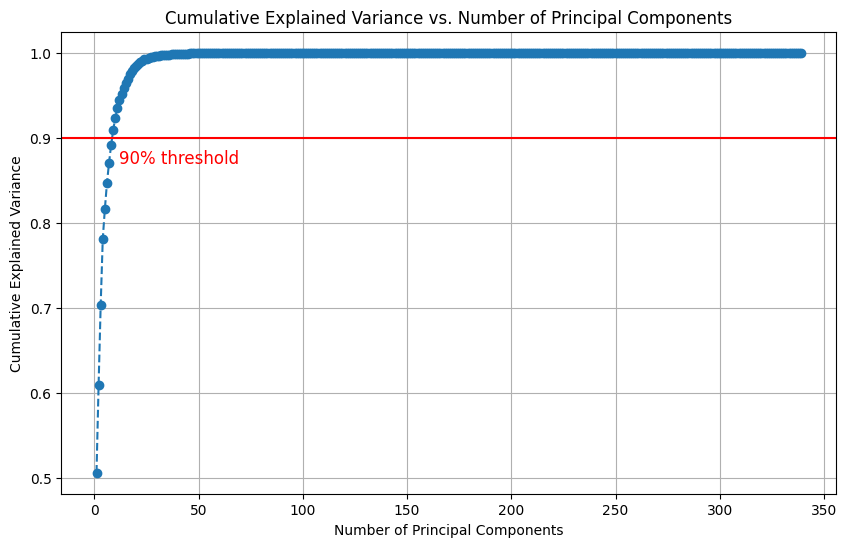


Number of components to retain for 90% variance: 9
Cumulative Explained Variance for the 9th component: 0.9088

   isFraud  TransactionAmt  ProductCD  card1  card2  card3  card4  card5  \
0        0            68.5          4  13926 -999.0  150.0      2  142.0   
1        0            29.0          4   2755  404.0  150.0      3  102.0   
2        0            59.0          4   4663  490.0  150.0      4  166.0   
3        0            50.0          4  18132  567.0  150.0      3  117.0   
4        0            50.0          1   4497  514.0  150.0      3  102.0   

   card6  addr1  ...  FraudRate_DeviceType        PC1       PC2       PC3  \
0      2  315.0  ...           -999.000000  -5.856051  0.516121 -4.189038   
1      2  325.0  ...           -999.000000  -6.550483 -0.156138  0.316624   
2      3  330.0  ...           -999.000000  -7.525757 -0.012620 -0.601479   
3      3  476.0  ...           -999.000000  -6.521062  1.595158  0.462121   
4      2  420.0  ...              0.101501  3

In [42]:
# cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(12, 0.87, '90% threshold', color='red', fontsize=12)
plt.grid()
plt.show()

comp_90 = next(i for i, total in enumerate(explained_variance) if total >= 0.90) + 1
print(f"\nNumber of components to retain for 90% variance: {comp_90}")
print(f"Cumulative Explained Variance for the {comp_90}th component: {explained_variance[comp_90-1]:.4f}\n")

v_data_pca_df = pd.DataFrame(v_data_pca[:, :comp_90], columns=[f'PC{i+1}' for i in range(comp_90)])
data_final = pd.concat([data.drop(columns=v_columns).reset_index(drop=True), v_data_pca_df], axis=1)

print(data_final.head())

# 6. Modeling

## 6.0 Functions

In [43]:
def tuneModel(model, param_grid, X_train, X_test, y_train, y_test, n_iter=50, cv=3, scoring='roc_auc', random_state=42):
    """
    perform hyperparameter tuning using RandomizedSearchCV and evaluate the model.
    
    Parameters:
    - model: the machine learning model to be tuned
    - param_grid: the parameter grid for RandomizedSearchCV
    - X_train: training features
    - y_train: training labels
    - X_test: testing features
    - y_test: testing labels
    - n_iter: number of parameter settings that are sampled. (default: 50)
    - cv: number of folds for cross-validation. (default: 3)
    - scoring: scoring metric. (default: 'roc_auc')
    - random_state: random seed. (default: 42)
    """
    
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=n_iter, cv=cv, scoring=scoring, verbose=1, random_state=random_state)
    
    random_search.fit(X_train, y_train)
    
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    print("Best parameters found: ", best_params)
    print("Best score found: ", best_score)
    
    best_model = random_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)
    
    metrics = evaluateModel(y_test, y_pred, y_pred_proba)

    
def evaluateModel(y_test, y_pred, y_pred_proba):
    """
    evaluate the model using various metrics and print the results
    
    Parameters:
    - y_test: testing labels
    - y_pred: predicted labels
    - y_pred_proba: predicted probabilities for the positive class
    """
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Basic Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Additional Metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Classification Report
    class_report = classification_report(y_test, y_pred)
    
    # Print Metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'Balanced Accuracy: {balanced_acc:.4f}')
    print(f'Matthew\'s Correlation Coefficient: {mcc:.4f}')
    print(f'Cohen\'s Kappa: {kappa:.4f}')
    print('\nClassification Report:')
    print(class_report)
    
    metrics = [accuracy, precision, recall, f1, roc_auc, balanced_acc, mcc, kappa]
    
    return metrics

In [44]:
def randomForestModel(X_train, X_test, y_train, y_test):
    """
    implement the Random Forest algorithm and print the evaluation metrics
    
    Parameters:
    - X_train: training features
    - X_test: testing features
    - y_train: training labels
    - y_test: testing labels
    """
    
    model = RandomForestClassifier(
        n_estimators = 500,
        min_samples_split = 4, 
        min_samples_leaf = 4, 
        max_depth = 20, 
        class_weight = 'balanced_subsample', 
        bootstrap = False,
        random_state = 42    
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    bold_start = "\033[1m"
    bold_end = "\033[0m"
    print(f"{bold_start}{'----------------------- Random Forest Model -----------------------'}{bold_end}")
    metrics = evaluateModel(y_test, y_pred, y_proba)
    
    return metrics


def xgbModel(X_train, X_test, y_train, y_test):
    """
    implement the XGBoost algorithm and print the evaluation metrics
    
    Parameters:
    - X_train: training features
    - X_test: testing features
    - y_train: training labels
    - y_test: testing labels
    """
    
    model = xgb.XGBClassifier(
        n_estimators = 300,
        max_depth = 6,
        learning_rate = 0.2,
        subsample = 1.0,
        colsample_bytree = 0.6,
        gamma = 0,
        min_child_weight = 3,
        scale_pos_weight = 1,
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42             
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    bold_start = "\033[1m"
    bold_end = "\033[0m"
    print(f"{bold_start}{'----------------------- XGBoost Model -----------------------'}{bold_end}")
    metrics = evaluateModel(y_test, y_pred, y_proba)
    
    return metrics


def lgbmModel(X_train, X_test, y_train, y_test): 
    """
    implement the LightGBM algorithm and print the evaluation metrics
    
    Parameters:
    - X_train: training features
    - X_test: testing features
    - y_train: training labels
    - y_test: testing labels
    """
    
    model = lgb.LGBMClassifier(
        objective = 'binary',         
        metric = 'binary_logloss',     
        subsample = 0.8, 
        scale_pos_weight = 3, 
        num_leaves = 50, 
        n_estimators = 300, 
        min_child_weight = 5, 
        max_depth = -1, 
        learning_rate = 0.2, 
        colsample_bytree = 0.8,
        random_state = 42,
        verbose = -1
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    bold_start = "\033[1m"
    bold_end = "\033[0m"
    print(f"{bold_start}{'----------------------- LightGBM Model -----------------------'}{bold_end}")
    metrics = evaluateModel(y_test, y_pred, y_proba)
    
    # Feature Importance Split
    lgb.plot_importance(model, max_num_features=20, importance_type='split', title='LightGBM Feature Importance (Split)')
    plt.show()
    
    # Feature Importance Gain
    lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(12,6), title='LightGBM Feature Importance (Gain)')
    plt.show()
    
    # ROC-AUC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'LightGBM (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='#8D8C8C', linestyle=':', label='Random Guess')
    plt.plot([0, 0, 1], [0, 1, 1], color='#463C3C', linestyle='--', label='Perfect Model')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return metrics


def catBoostModel(X_train, X_test, y_train, y_test):
    """
    implement the CatBoost algorithm and print the evaluation metrics
    
    Parameters:
    - X_train: training features
    - X_test: testing features
    - y_train: training labels
    - y_test: testing labels
    """
    
    model = CatBoostClassifier(
        iterations = 300,                
        depth = 4,                       
        learning_rate = 0.2, 
        scale_pos_weight = 3,
        l2_leaf_reg = 3,
        border_count = 50,
        bagging_temperature = 1.0,
        loss_function = 'Logloss',       
        eval_metric = 'AUC',              
        cat_features = categorical_columns, 
        random_state = 42,
        silent = True
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]   # Probabilities for the positive class
    
    bold_start = "\033[1m"
    bold_end = "\033[0m"
    print(f"{bold_start}{'----------------------- CatBoost Model -----------------------'}{bold_end}")
    metrics = evaluateModel(y_test, y_pred, y_proba)
    
    return metrics

## 6.1 Data Splitting

In [45]:
X = data_final.drop(columns=['isFraud'])
y = data_final['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 6.2 Model Tuning

To run the code blocks below, remove the triple quotes (""") surrounding the code.

In [46]:
"""xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 3, 5]  # useful for imbalanced datasets
}
    
tuneModel(xgb_model, rf_param_grid, X_train, X_test, y_train, y_test)"""

"xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')\n\nrf_param_grid = {\n    'n_estimators': [50, 100, 200, 300],\n    'max_depth': [3, 4, 5, 6],\n    'learning_rate': [0.01, 0.05, 0.1, 0.2],\n    'subsample': [0.6, 0.8, 1.0],\n    'colsample_bytree': [0.6, 0.8, 1.0],\n    'gamma': [0, 0.1, 0.2, 0.3],\n    'min_child_weight': [1, 3, 5],\n    'scale_pos_weight': [1, 3, 5]  # useful for imbalanced datasets\n}\n    \ntuneModel(xgb_model, rf_param_grid, X_train, X_test, y_train, y_test)"

In [47]:
"""lgbm_model = lgb.LGBMClassifier(verbose=-1)

lgbm_param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [1, 3, 5]  # useful for imbalanced datasets
}

tuneModel(lgbm_model, lgbm_param_grid, X_train, X_test, y_train, y_test)"""

"lgbm_model = lgb.LGBMClassifier(verbose=-1)\n\nlgbm_param_grid = {\n    'num_leaves': [31, 50, 70],\n    'max_depth': [-1, 10, 20, 30],\n    'learning_rate': [0.01, 0.05, 0.1, 0.2],\n    'n_estimators': [50, 100, 200, 300],\n    'subsample': [0.6, 0.8, 1.0],\n    'colsample_bytree': [0.6, 0.8, 1.0],\n    'min_child_weight': [1, 5, 10],\n    'scale_pos_weight': [1, 3, 5]  # useful for imbalanced datasets\n}\n\ntuneModel(lgbm_model, lgbm_param_grid, X_train, X_test, y_train, y_test)"

In [48]:
"""catboost_model = CatBoostClassifier(silent=True)

catboost_param_grid = {
    'iterations': [50, 100, 200, 300],
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 50, 100],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'scale_pos_weight': [1, 3, 5]
}

tuneModel(catboost_model, catboost_param_grid, X_train, X_test, y_train, y_test)"""

"catboost_model = CatBoostClassifier(silent=True)\n\ncatboost_param_grid = {\n    'iterations': [50, 100, 200, 300],\n    'depth': [3, 4, 5, 6],\n    'learning_rate': [0.01, 0.05, 0.1, 0.2],\n    'l2_leaf_reg': [1, 3, 5, 7],\n    'border_count': [32, 50, 100],\n    'bagging_temperature': [0.0, 0.5, 1.0],\n    'scale_pos_weight': [1, 3, 5]\n}\n\ntuneModel(catboost_model, catboost_param_grid, X_train, X_test, y_train, y_test)"

In [49]:
"""rf_model = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']  # useful for imbalanced datasets
}

tuneModel(rf_model, rf_param_grid, X_train, X_test, y_train, y_test)"""

"rf_model = RandomForestClassifier()\n\nrf_param_grid = {\n    'n_estimators': [50, 100, 200, 300],\n    'max_depth': [None, 10, 20, 30],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'bootstrap': [True, False],\n    'class_weight': [None, 'balanced', 'balanced_subsample']  # useful for imbalanced datasets\n}\n\ntuneModel(rf_model, rf_param_grid, X_train, X_test, y_train, y_test)"

**OUTPUT**

* RandomForestClassifier

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found:  {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 20, 'class_weight': 'balanced_subsample', 'bootstrap': False}

---------------------------------------------------------------------------------------------------
* XGBoostClassifier

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found:  {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}

---------------------------------------------------------------------------------------------------
* LGBMClassifier

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found:  {'subsample': 0.8, 'scale_pos_weight': 3, 'num_leaves': 50, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': -1, 'learning_rate': 0.2, 'colsample_bytree': 0.8}

---------------------------------------------------------------------------------------------------
* CatBoostClassifier

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found:  {'scale_pos_weight': 3, 'learning_rate': 0.2, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 4, 'border_count': 50, 'bagging_temperature': 1.0}

## 6.3 Model Application & Evaluation

----------------------- Random Forest Model -----------------------


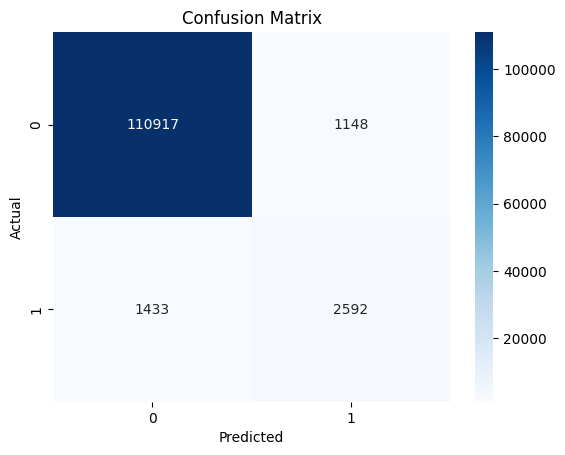

Accuracy: 0.9778
Precision: 0.6930
Recall: 0.6440
F1 Score: 0.6676
ROC-AUC: 0.9432
Balanced Accuracy: 0.8169
Matthew's Correlation Coefficient: 0.6566
Cohen's Kappa: 0.6561

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    112065
           1       0.69      0.64      0.67      4025

    accuracy                           0.98    116090
   macro avg       0.84      0.82      0.83    116090
weighted avg       0.98      0.98      0.98    116090



In [46]:
rf_metrics = randomForestModel(X_train, X_test, y_train, y_test)

c:\Users\dhanu\.conda\envs\idk_gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [23:22:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


----------------------- XGBoost Model -----------------------


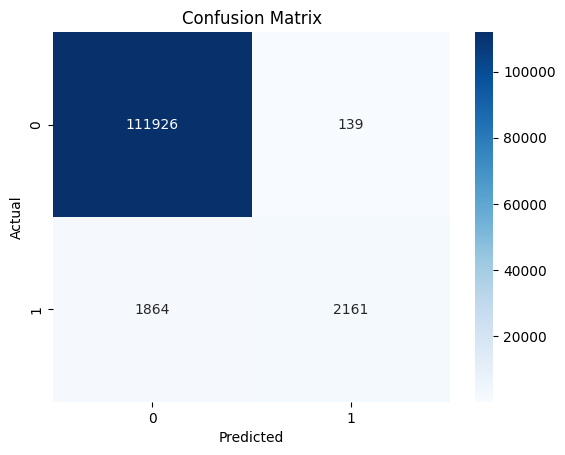

Accuracy: 0.9827
Precision: 0.9396
Recall: 0.5369
F1 Score: 0.6833
ROC-AUC: 0.9546
Balanced Accuracy: 0.7678
Matthew's Correlation Coefficient: 0.7032
Cohen's Kappa: 0.6751

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    112065
           1       0.94      0.54      0.68      4025

    accuracy                           0.98    116090
   macro avg       0.96      0.77      0.84    116090
weighted avg       0.98      0.98      0.98    116090



In [47]:
xgb_metrics = xgbModel(X_train, X_test, y_train, y_test)

----------------------- LightGBM Model -----------------------


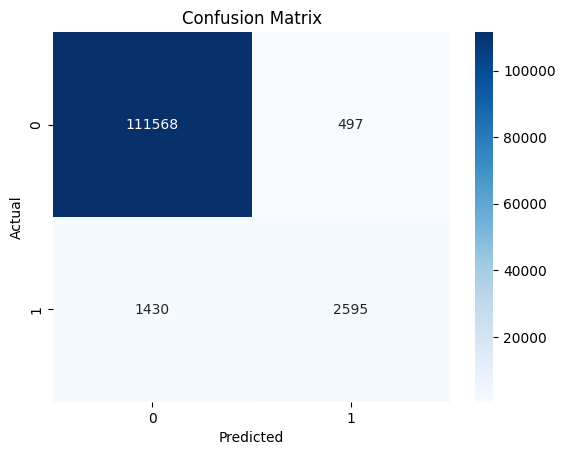

Accuracy: 0.9834
Precision: 0.8393
Recall: 0.6447
F1 Score: 0.7292
ROC-AUC: 0.9606
Balanced Accuracy: 0.8201
Matthew's Correlation Coefficient: 0.7275
Cohen's Kappa: 0.7208

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    112065
           1       0.84      0.64      0.73      4025

    accuracy                           0.98    116090
   macro avg       0.91      0.82      0.86    116090
weighted avg       0.98      0.98      0.98    116090



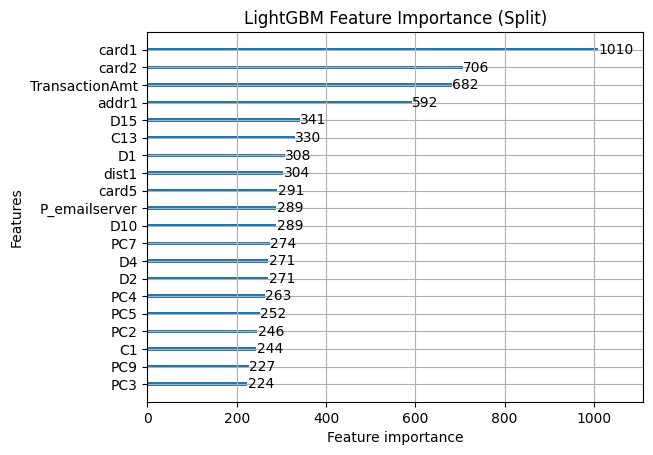

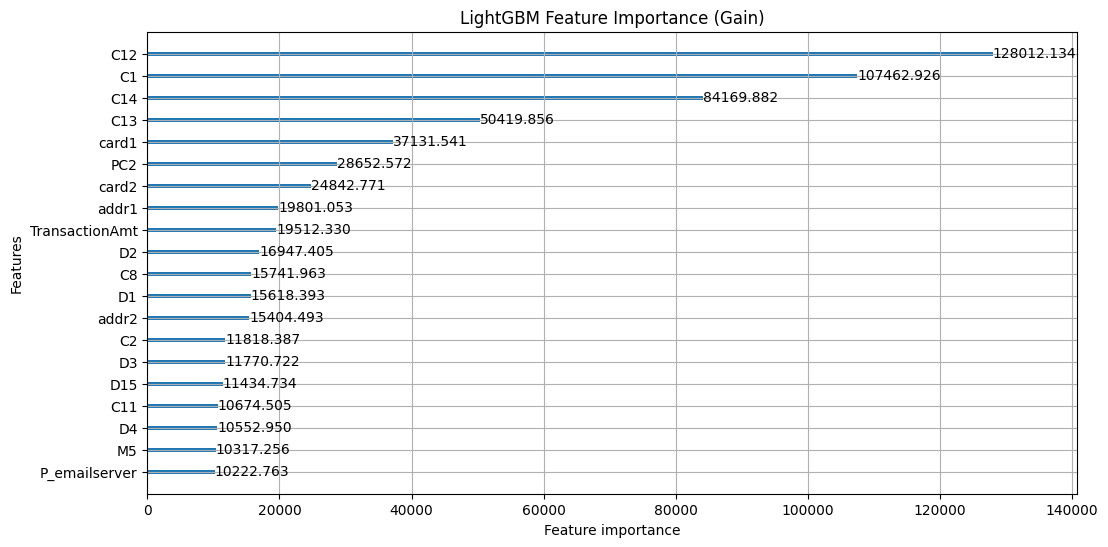

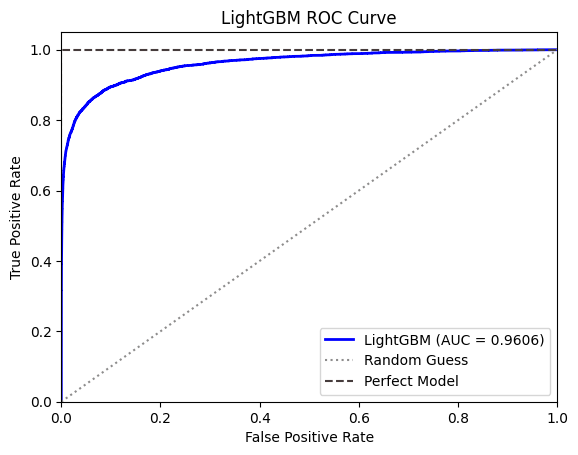

In [48]:
lgbm_metrics = lgbmModel(X_train, X_test, y_train, y_test)

----------------------- CatBoost Model -----------------------


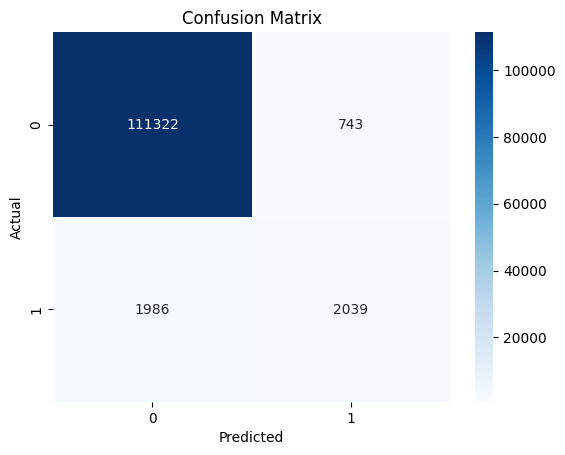

Accuracy: 0.9765
Precision: 0.7329
Recall: 0.5066
F1 Score: 0.5991
ROC-AUC: 0.9196
Balanced Accuracy: 0.7500
Matthew's Correlation Coefficient: 0.5981
Cohen's Kappa: 0.5874

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    112065
           1       0.73      0.51      0.60      4025

    accuracy                           0.98    116090
   macro avg       0.86      0.75      0.79    116090
weighted avg       0.97      0.98      0.97    116090



In [49]:
cat_metrics = catBoostModel(X_train, X_test, y_train, y_test)

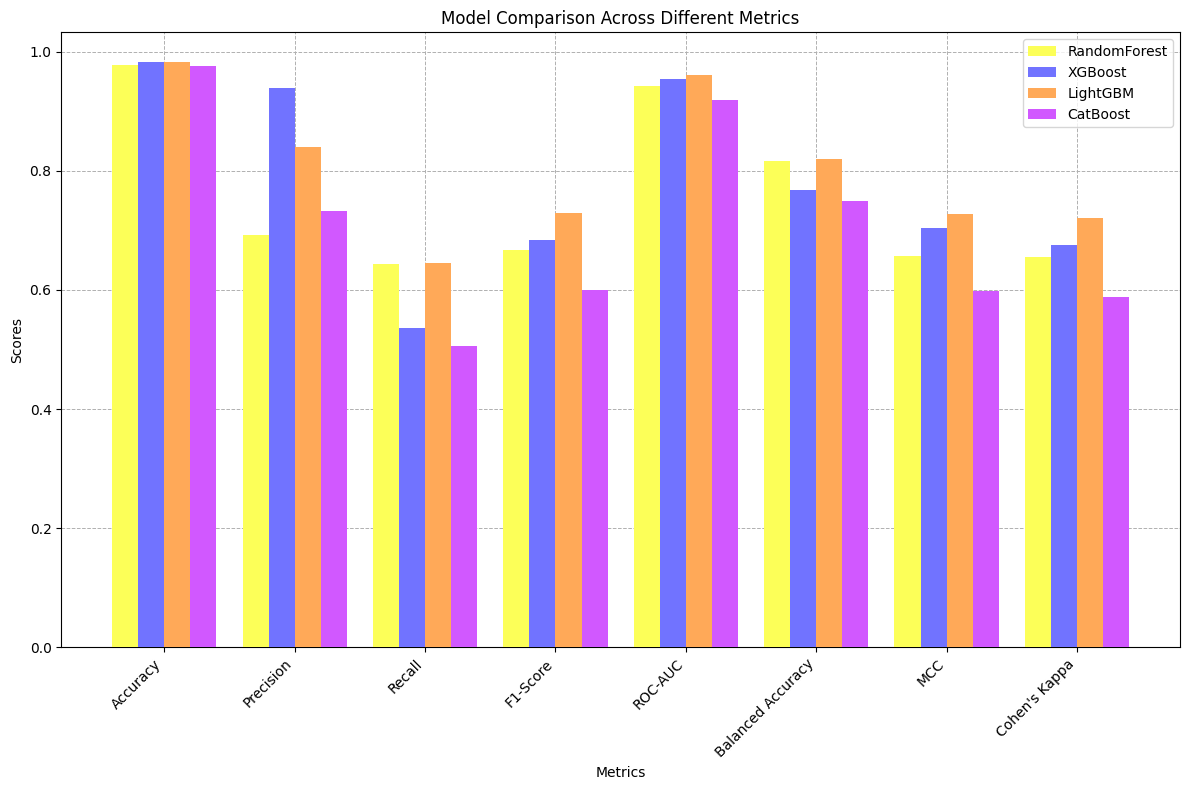

In [50]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Balanced Accuracy', 'MCC', 'Cohen\'s Kappa']

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
bar_positions = np.arange(len(metrics))

ax.grid(True, which='both', linestyle='--', linewidth=0.7, zorder=0)
colors = ['#fcff58', '#7173ff', '#ffa958', '#d158ff']
models = ['RandomForest','XGBoost', 'LightGBM', 'CatBoost']

ax.bar(bar_positions - 1.5 * bar_width, rf_metrics, bar_width, label='RandomForest', color=colors[0], zorder=3)
ax.bar(bar_positions - 0.5 * bar_width, xgb_metrics, bar_width, label='XGBoost', color=colors[1], zorder=3)
ax.bar(bar_positions + 0.5 * bar_width, lgbm_metrics, bar_width, label='LightGBM', color=colors[2], zorder=3)
ax.bar(bar_positions + 1.5 * bar_width, cat_metrics, bar_width, label='CatBoost', color=colors[3], zorder=3)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison Across Different Metrics')
ax.set_xticks(bar_positions)
ax.set_xticklabels(metrics)
ax.legend()


plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()